# LigandMPNN: Atomic Context-Conditioned Protein Sequence Design Colab v1.0


This notebook provides an easy-to-use implementation of LigandMPNN for atomic context-conditioned protein sequence design ([Dauparas et al. 2023](https://www.biorxiv.org/content/10.1101/2023.12.22.573103v1.full)) created by <b><font color='gold'>Logan Hessefort</font></b> ([LinkedIn](https://www.linkedin.com/in/logan-hessefort/)) as part of a <b><font color='green'>US Department of Energy SCGSR award</font></b> ([details](https://science.osti.gov/wdts/scgsr)) with additional support from the <b><font color='DodgerBlue'>US National Science Foundation</font></b> ([grant](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2132183&HistoricalAwards=false)).

For more details on the model, refer to the [LigandMPNN GitHub repository](https://github.com/dauparas/LigandMPNN).


**Authors**:

Justas Dauparas ([LinkedIn](https://www.linkedin.com/in/justasdauparas/)), Gyu Rie Lee, Robert Pecoraro, Linna An, Ivan Anishchenko, Cameron Glasscock, David Baker

**License**:

The code and model parameters used in this notebook are available under the ([MIT license](https://opensource.org/license/mit)).

**Acknowledgments**:

Major thanks to the authors for producing these profoundly impactful models.

**Bugs**:

Reach out to me over email lhessefo@asu.edu



_____________________________________________________________________________

## Notes for getting started:


*   The following cell will need to be run in order. **Do not hit run all**!


<b><font color='red'>IMPORTANT DISCLAIMER</font></b>: This model was **trained** on experimentally determined protein-ligand complexes from X-ray diffraction densities and cryo-EM maps from the Protein Data Bank. It is likely the case that using computationally determined complexes will produce inferior results as compared to redesigning experimentally determined complexes.

However, the authors of ([this paper](https://www.biorxiv.org/content/10.1101/2023.11.01.565201v1.full.pdf)) use LigandMPNN, RIFDock, and GALigandDock to generate  redesigned small molecule binders to great avail. **The use of other docking techniques is not mentioned**. In this paper the authors use an iterative approach to designing using LigandMPNN, where redesigned proteins are redocked to the ligand of interest and redesigned again with LigandMPNN for atleast a total of 2 iterations. They use a temperature of 0.2 and a batch size of 8.

<b><font color='pink'>If you are using an experimentally determined complex from the Protein Data Bank you do not need to perform the following steps and you can simply upload the pdb file to the specified Google Drive Directory.</font></b>

1. **Creation of the input pdb file for computationally determined structures**:
   - To run LigandMPNN, you will need a pdb file that contains the ligand and the protein structure in one pdb file. Theoretically any docking algoritm could be used such for generating binding poses DiffDock, AutoDock Vina, NeuralPlexar, GLIDE etc.
   - For simple use of DiffDock-L on HuggingFace, see ([DiffDock-web](https://huggingface.co/spaces/reginabarzilaygroup/DiffDock-Web))
   - For simple use of Vina, see ([SwissDock](https://www.swissdock.ch/))

2. **Structure ligand Complex Analysis**:
  - When using computationally docked ligands it is of the utmost importance to confirm that the complex generated appears realistic and in the case of enzymes ensuring the ligand is bound in a catalytically relavent position as compared to similar ligands bound to experimentally determined structures in the Protein Data Bank.
  - **The most accurate ligand pose may not be the one with the highest confidence or lowest predicted binding energy.**
  - The authors of the ([this paper](https://www.biorxiv.org/content/10.1101/2023.11.01.565201v1.full.pdf)) out of the Baker group use Rosetta Fast Relax to relax any clashed residues for the generated complexes, however, this is not a requirement.

3. **Generating your LigandMPNN ready PDB file**:
  - Once you have determined the pose you believe to be most accurate, open both your experimentally determined 'receptor' protein and your docked ligand in PyMol.
  - For DiffDock, you will be opening the sdf file and for Vina you will be opening the pdbqt file. For the pdbqt file, ensure you have used the 'forward' arrow to go to the frame that contains the most accurate binding position.
  - Now in PyMol, go to file > Export Molecule > save > *name the file* > *in the save as type box at the bottom of the popup change from .cif to .pdb* > *save in the file location of your choice*

4. **Converting Ligand from UNK to LIG in the PDB file**:
  
  I have provided the way I have found to do this although there are likely simplier methods.
  - Open the generated protein-ligand complex pdb file in VSCode (https://code.visualstudio.com/download).
  - Find the ligand portion of the pdb file, it will either be found at the top of bottom of the file with the residue identifier 'UNK'. Single click on once of the UNKs. This should highlight all the entire column.
  - Use Ctrl + Shift + L or (CMD + Shift + L) to cursor over the entire column.
  - Backspace the UNK and type "LIG"
  - Now go to the ligand columns that contain 0.00, these are the b-factor and occupancy columns.
  - Single click one of the columns, ctrl + shift + l then replace the 0.00 with 1.00. It should replace both columns at once.
  -Save the pdb file and upload it to the proper LigandMPNN file path "/content/drive/MyDrive/LigandMPNN/inputs/"

2. **Runtime**:
  - You will want to run this on a T4 GPU runtime. Please go to runtime > change runtime type > T4 GPU.
________________________________________________________________________________


## Mount Google Drive (ensure you are on a T4 GPU runtime)

This cell mounts your Google Drive to the Colab environment. By doing so, you can access files stored in your Google Drive directly from the Colab notebook. Personally, I find this useful for file management, especially for input files, and output results as compared to using the drive premounted to colab.

In [ ]:
# @title
from google.colab import drive

drive.mount('/content/drive')

## Set Up the Environment and Install Dependencies

This cell performs several tasks to set up the necessary environment for running LigandMPNN. It clones the LigandMPNN repository, and installs the required packages. It will take ~3-5 minutes to complete.

The default paths are created for you at the file paths /content/drive/MyDrive/LigandMPNN/inputs and /content/drive/MyDrive/LigandMPNN/outputs. If you wish to change them you will have to do so in the code of this cell.

<b><font color='cyan'>This cell will ask you to restart your session, ensure you do so. Then rerun the cell one more time.</font></b>


In [ ]:
# @title
import os
import sys

# Clone the LigandMPNN repository
!git clone https://github.com/dauparas/LigandMPNN.git
%cd LigandMPNN

# Install required packages
!pip install -r requirements.txt

# Download the model parameters
!bash get_model_params.sh "./model_params"

# Set up paths
input_dir = '/content/drive/MyDrive/LigandMPNN/inputs'
output_dir = '/content/drive/MyDrive/LigandMPNN/outputs'

# Ensure necessary directories are in place
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Add the current directory to Python path
sys.path.append(os.getcwd())

print("Setup completed successfully!")

## Configure LigandMPNN Parameters

This cell sets up the necessary parameters for running LigandMPNN. Here's what each section does:

1. **File Paths**:
   - Sets up directories for input files and output results.
   - Asks you to input the name of your PDB file.

2. **Advanced Settings**:
   - **Temperature**: Controls sequence diversity. Higher values increase diversity. A 0.1 temperature will change ~10-20% of residues.
   - **Batch Size**: Number of sequences to process simultaneously. Smaller batch sizes with more batches appears to increase sequence diversity.
   - **Number of Batches**: Total number of batches to process.

3. **Residue Specification**:
   - **Fixed Residues**: Option to specify residues that should not be modified (e.g., catalytic residues).
   - **Redesigned Residues**: Option to specify only the residues that should be modified.
   - You can choose to use either fixed or redesigned residues by checking the respective boxes. You must specify in the residues in the box and click the respective box for this to work properly.
   - Text files will be saved with the fixed and/or redesigns at the input path.

4. **Configuration Processing**:
   - Creates a configuration dictionary (`mpnn_config`) with all the specified parameters.
   - If fixed or redesigned residues are specified, it adds them to the configuration and saves them to separate files for reference.

5. **Output**:
   - Prints the final configuration, showing all the parameters that will be used in the LigandMPNN run. Please confirm these are the parameters you want.
________________________________________________________________________________

In [ ]:
import os

input_dir = '/content/drive/MyDrive/LigandMPNN/inputs'
output_dir = '/content/drive/MyDrive/LigandMPNN/outputs'

# Check if the directories exist
if not os.path.exists(input_dir) or not os.path.exists(output_dir):
    print("ERROR: Input or output directory not found.")
    print("Please ensure you have mounted your Google Drive and that the following paths exist:")
    print(f"Input directory: {input_dir}")
    print(f"Output directory: {output_dir}")
    print("\nAfter mounting, please create the necessary directories in your Google Drive if they don't exist.")
    raise FileNotFoundError("Input or output directory not found")

#@markdown The pdb file should be placed in your inputs directory and ensure to include .pdb (e.g. 8VGX.pdb).
pdb_file_name = "" #@param {type:"string"}
pdb_file_path = os.path.join(input_dir, pdb_file_name)

#@markdown ---
#@markdown # **Advanced settings**

# @markdown **A higher temperature gives more sequence diversity**
temperature = 0.1 #@param {type:"number"}
# @markdown Using between 0.05 and 0.2 produces good sequence diversity.

# @markdown **Batch size for processing**
batch_size = 2 #@param {type:"integer"}
# @markdown In my experience, using a smaller batch size with more batches produces higher sequence diversity with less bias towards similar residue changes.

# @markdown **Number of batches to process**
number_of_batches = 5 #@param {type:"integer"}

# @markdown If you wish to specify residues which should not be modified or specify the only residues which should be modified then enter the residues you want to fix or redesign below. Separate multiple residues with spaces and ensure you have the chain ID leading the residue number.


fixed_residues_input = "A164 A165 " #@param {type:"string"}
# @markdown Fixing residues is particularly important when your protein contains **catalytic residues** which cannot be modified.
redesigned_residues_input = "" #@param {type:"string"}

#@markdown Check the box if you want to specify **fixed residues**.
use_fixed_residues = False #@param {type:"boolean"}

#@markdown Check the box if you want to specify **the only residues that will be redesigned**.
use_redesign_residues = False #@param {type:"boolean"}

# Process inputs
fixed_residues_path = os.path.join(input_dir, 'fixed_residues.txt')
redesigned_residues_path = os.path.join(input_dir, 'redesigned_residues.txt')

# Prepare configuration for LigandMPNN
mpnn_config = {
    "pdb_path": pdb_file_path,
    "out_folder": output_dir,
    "temperature": temperature,
    "batch_size": batch_size,
    "number_of_batches": number_of_batches
}


# Process fixed residues
if use_fixed_residues:
    mpnn_config["fixed_residues"] = fixed_residues_input.strip()
    with open(fixed_residues_path, 'w') as f:
        f.write(mpnn_config["fixed_residues"])
    print(f"Fixed residues saved to: {fixed_residues_path}")

# Process redesigned residues
if use_redesign_residues:
    mpnn_config["redesigned_residues"] = redesigned_residues_input.strip()
    with open(redesigned_residues_path, 'w') as f:
        f.write(mpnn_config["redesigned_residues"])
    print(f"Redesigned residues saved to: {redesigned_residues_path}")

# Print final configuration
print("\nFinal LigandMPNN configuration:")
for key, value in mpnn_config.items():
    print(f"{key}: {value}")

## Run LigandMPNN

This cell executes the LigandMPNN algorithm using the parameters you specified earlier. It should take about 30 seconds to run.

Here's what's happening:

1. It constructs a command to run LigandMPNN based on your inputs.
2. The command includes:
   - The model type (ligand_mpnn)
   - A seed for reproducibility (default is 80401)
   - The path to your input PDB file
   - The output folder for results
   - The temperature for sequence diversity
   - The number of batches and batch size for processing
   - Any fixed or redesigned residues you specified (if applicable)

3. The cell prints out the full command so you can verify it.
4. Finally, it executes the command to run LigandMPNN.

This process will generate redesigned protein sequences in fasta format based on your input structure and parameters. The results will be saved in the specified output folder. Note that the first sequence in the fasta will be the same as the input structure.

In [ ]:
# @title
# Construct the run command using the mpnn_config dictionary
run_command = f"""python run.py \
    --model_type "ligand_mpnn" \
    --seed 80401 \
    --pdb_path {mpnn_config['pdb_path']} \
    --out_folder {mpnn_config['out_folder']} \
    --temperature {mpnn_config['temperature']} \
    --number_of_batches {mpnn_config['number_of_batches']} \
    --batch_size {mpnn_config['batch_size']}"""

# Add fixed_residues if specified
if 'fixed_residues' in mpnn_config:
    run_command += f" \\\n    --fixed_residues \"{mpnn_config['fixed_residues']}\""

# Add redesigned_residues if specified
if 'redesigned_residues' in mpnn_config:
    run_command += f" \\\n    --redesigned_residues \"{mpnn_config['redesigned_residues']}\""

# Print the command (for verification)
print("Run command:")
print(run_command)

# Execute the command
!{run_command}



---


#Next Steps


*   Now that you have your fasta files the first spot test to see if they are good designs is to fold them. An easy way to do that is to use ([ColabFold Batch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb)). If you have colab pro use a TPU v2 for ColabFold, it is much faster than a T4.

*   Once you have your redesigned pdb files you can redock the ligands using AutoDock Vina ([SwissDock](https://www.swissdock.ch/)) or ([DiffDock-web](https://huggingface.co/spaces/reginabarzilaygroup/DiffDock-Web)).

*   These redesigns will not always show higher affinity in computational docking experiments! Some protein architectures appear to perform better than others when using LigandMPNN. It is important to visually inspect as well as use these metrics for decision making on whether to express these designs *in vitro*.


*   The authors of ([this paper](https://www.biorxiv.org/content/10.1101/2023.11.01.565201v1.full.pdf)) out of the Baker group used Rosetta to calculate the number of hydrogen bonds between the protein and ligand, the binding energy (ddG), and contact molecular surface (CMS) between the ligand and protein to filter between binder designs. This multi-metric approach is likely the best option for filtering large numbers of binders, however, for small numbers of designs visual anaylsis by you is even better!
  * Another note about this paper, is they performed interative redesign up to 2 times and selected the best from these further iterations for expression.


*   Before you order any DNA use a tool like ([COMPSS](https://colab.research.google.com/github/seanrjohnson/protein_scoring/blob/main/colab_notebooks/Protein_Metrics.ipynb)) to determine if the designs are likely to recombinantly express and function *in vitro*.

  * Interpreting the metrics from COMPSS:
  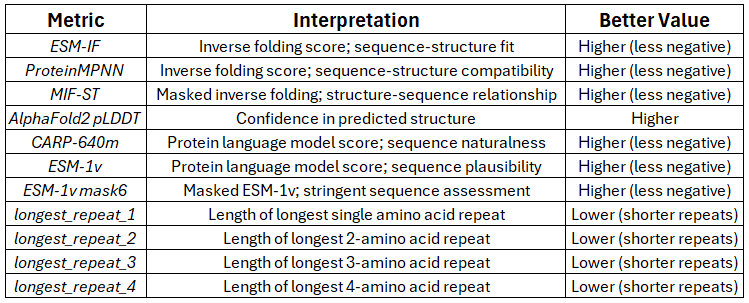

  * Before running COMPSS, ensure you do not have any spaces in the name of the files or in the fasta names, like the default names for LigandMPNN. This will prevent the running of some of the metrics.







